##### **I. Install Required Libraries**

In [1]:
# Install the following libraries:
# - PyTorch
# - TorchVision (PyTorch)
# - Azure Machine Learning (ML) SDK
!pip install torch torchvision azureml-sdk

##### **II. Import Required Libraries**

In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v2, shufflenet_v2_x1_0, squeezenet1_1
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F

##### **III. Load Models**

In [3]:
# Define the paths of the saved models
mobilenet_model_path = "models/mobilenetv2_model.pth"
shufflenet_model_path = "models/shufflenetv2_model.pth"
squeezenet_model_path = "models/squeezenet1_1_model.pth"

In [4]:
# Load the models from the saved paths
mobilenet_model = mobilenet_v2()
mobilenet_model.classifier[1] = torch.nn.Linear(in_features=1280, out_features=3, bias=True)
mobilenet_model.load_state_dict(torch.load(mobilenet_model_path))
mobilenet_model.eval()

shufflenet_model = shufflenet_v2_x1_0()
shufflenet_model.fc = torch.nn.Linear(in_features=1024, out_features=3, bias=True)
shufflenet_model.load_state_dict(torch.load(shufflenet_model_path))
shufflenet_model.eval()

squeezenet_model = squeezenet1_1()
squeezenet_model.classifier[1] = torch.nn.Conv2d(512, 3, kernel_size=(1, 1), stride=(1, 1))
squeezenet_model.load_state_dict(torch.load(squeezenet_model_path))
squeezenet_model.eval()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

##### **IV. Image Processing**

In [5]:
# Define the transformations for input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

##### **V. Define display names of each model**

In [6]:
# Define the models dictionary
models = {
    "MobileNet-V2": mobilenet_model,
    "ShuffleNet-V2": shufflenet_model,
    "SqueezeNet 1.1": squeezenet_model
}

##### **VI. Predict X-ray Images**



'X-ray Image 1'


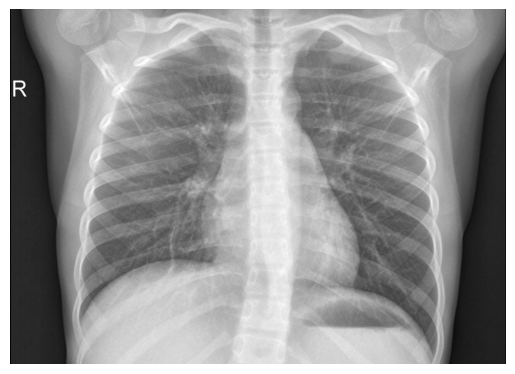

            Model Predicted Class Real Class  Correct  Confidence
0    MobileNet-V2          Normal     Normal     True      0.9996
1   ShuffleNet-V2          Normal     Normal     True      0.9999
2  SqueezeNet 1.1          Normal     Normal     True      0.9222


'X-ray Image 2'


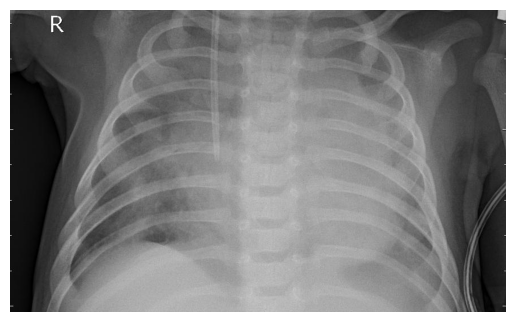

            Model      Predicted Class           Real Class  Correct  \
0    MobileNet-V2  Bacterial Pneumonia  Bacterial Pneumonia     True   
1   ShuffleNet-V2  Bacterial Pneumonia  Bacterial Pneumonia     True   
2  SqueezeNet 1.1               Normal  Bacterial Pneumonia    False   

   Confidence  
0      0.9553  
1      0.9976  
2      0.3350  


'X-ray Image 3'


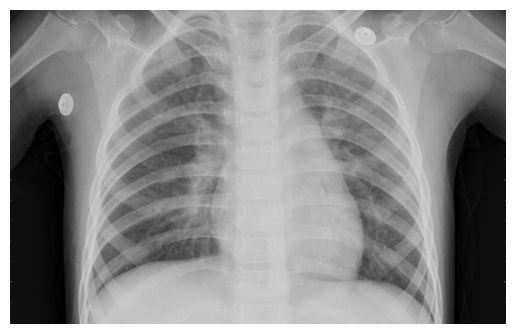

            Model  Predicted Class       Real Class  Correct  Confidence
0    MobileNet-V2  Viral Pneumonia  Viral Pneumonia     True      0.7970
1   ShuffleNet-V2  Viral Pneumonia  Viral Pneumonia     True      0.4319
2  SqueezeNet 1.1           Normal  Viral Pneumonia    False      0.4179


'X-ray Image 4'


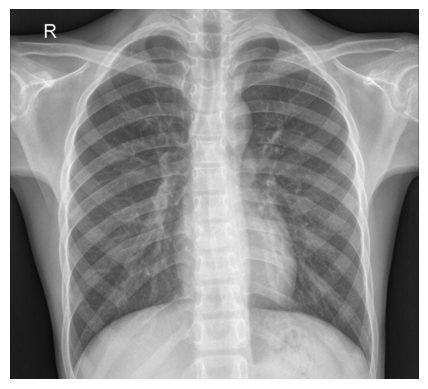

            Model Predicted Class Real Class  Correct  Confidence
0    MobileNet-V2          Normal     Normal     True      0.9994
1   ShuffleNet-V2          Normal     Normal     True      1.0000
2  SqueezeNet 1.1          Normal     Normal     True      0.8516


'X-ray Image 5'


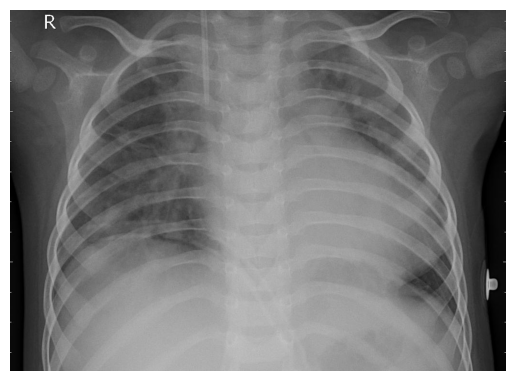

            Model      Predicted Class           Real Class  Correct  \
0    MobileNet-V2  Bacterial Pneumonia  Bacterial Pneumonia     True   
1   ShuffleNet-V2  Bacterial Pneumonia  Bacterial Pneumonia     True   
2  SqueezeNet 1.1               Normal  Bacterial Pneumonia    False   

   Confidence  
0      0.9379  
1      0.9668  
2      0.3420  


In [7]:
# List of test image paths
test_image_paths = [
    "dataset/chest_xray/test/Normal/IM-0003-0001.jpeg",
    "dataset/chest_xray/test/Bacterial Pneumonia/person100_bacteria_480.jpeg",
    "dataset/chest_xray/test/Viral Pneumonia/person72_virus_133.jpeg",
    "dataset/chest_xray/test/Normal/IM-0005-0001.jpeg",
    "dataset/chest_xray/test/Bacterial Pneumonia/person101_bacteria_485.jpeg"
]

# Iterate through each test image
for i, test_image_path in enumerate(test_image_paths, start=1):
    print(f"\n\n'X-ray Image {i}'")

    # Load the test image
    test_image = Image.open(test_image_path).convert('RGB')

    # Display the test image
    plt.imshow(test_image)
    plt.axis('off')
    plt.show()

    # Create a dataframe to store the predictions for this image
    predictions = {'Model': [], 'Predicted Class': [], 'Real Class': [], 'Correct': [], 'Confidence': []}

    # Real class of the test image
    real_class = test_image_path.split('/')[-2]

    # Iterate through each model and make predictions
    for model_name, model in models.items():
        # Apply transformations to the test image
        input_image = transform(test_image).unsqueeze(0)

        # Make prediction
        with torch.no_grad():
            output = model(input_image)
            probabilities = F.softmax(output, dim=1)
            confidence, predicted = torch.max(probabilities, 1)

        # Decode the predicted class
        class_names = ['Bacterial Pneumonia', 'Normal', 'Viral Pneumonia']
        predicted_class = class_names[predicted.item()]

        # Determine if prediction is correct
        correct = real_class == predicted_class

        # Add the predictions to the dictionary
        predictions['Model'].append(model_name)
        predictions['Predicted Class'].append(predicted_class)
        predictions['Real Class'].append(real_class)
        predictions['Correct'].append(correct)
        predictions['Confidence'].append(round(confidence.item(), 4))  # Round to 4 decimal places

    # Create a dataframe from the predictions dictionary
    df = pd.DataFrame(predictions)

    # Display the dataframe
    print(df)